# Exploring transfer learning - part3

Bertrand Thia (bt2513)

This time, we are going to work with the network Xception.

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from keras.preprocessing import image
from keras.applications import Xception
from keras.utils import to_categorical

np.random.seed(0)

# Loading the data and data preprocessing

In [2]:
train_labels = pd.read_csv('../train.csv')

### Splitting into training set and validation set 

In [3]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

In [4]:
print('Train size: %d \t Validation size: %d' %(len(train_set), len(valid_set)))

Train size: 901 	 Validation size: 226


In [5]:
train_set['label'].value_counts()

normal       280
bacterial    280
viral        280
covid         61
Name: label, dtype: int64

### Standardization

Let's load and standardized our data. To address the overfitting issue, we are going to use data augmentation here. This will allow us to increase the size of our dataset, but also make the classification more challenging. Since the network is deep, we are going to use aggresive modifications:

In [10]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  rotation_range= 20,
                                  horizontal_flip= True,
                                  shear_range= 0.2,
                                  zoom_range= 0.2)

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

Let's use the same parameters as previously:

In [11]:
BATCH_SIZE = 32
W = 312
H = 251

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train2/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (H, W),
                                            batch_size= BATCH_SIZE, 
                                            shuffle= False)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (H, W),
                                        batch_size= BATCH_SIZE, 
                                        shuffle= False)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are going to use the network ResNet50 and pre-trained weights from the ImageNet dataset:

In [12]:
model = Xception(include_top=False, weights='imagenet')

As it is very expansive to run the whole network, we are going to only do it once and save the output at the end of the pre-trained part of the network. We will then train fully-connected layers for the top layers of the model.

In [13]:
bottleneck_features_train = model.predict_generator(X_train, steps= len(train_set) // BATCH_SIZE)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_val = model.predict_generator(X_val, steps= len(valid_set) // BATCH_SIZE)
np.save(open('bottleneck_features_val.npy', 'wb'), bottleneck_features_val)

### Training the top layers 

In [14]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_y = to_categorical(train_set['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}).values[:-5])

validation_data = np.load(open('bottleneck_features_val.npy', 'rb'))
validation_y = to_categorical(valid_set['label'].map({'bacterial': 0, 'covid': 1, 
                                                     'normal': 2, 'viral': 3}).values[:-2])

In [15]:
print('Size of the training: %d \t labels: %d' %(len(train_data), len(train_y)))
print('Size of the validation: %d \t labels: %d' %(len(validation_data), len(validation_y)))

Size of the training: 896 	 labels: 896
Size of the validation: 224 	 labels: 224


Since we are using batches of data, we don't end up with the whole dataset, but this will allow to speed up the process.

Since this network is very deep and different from the previous one, we are going to modify our fully connected layers here. We obtained satisfying results with the following structure:

In [30]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(units= 256, activation= 'relu')) 
top_model.add(Dropout(0.4)) 
top_model.add(Dense(units= 128, activation= 'relu')) 
top_model.add(Dropout(0.25)) 
top_model.add(Dense(units= 16, activation= 'relu'))
top_model.add(Dense(units= 4, activation= 'softmax'))

top_model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(lr= 1e-4), 
              metrics = ['accuracy'])

In [31]:
epochs= 30
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 3)
filepath="./weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

Since our dataset is imbalanced, we are going to use class weigthing to address the issue:

In [32]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [33]:
hist = top_model.fit(train_data, train_y,
                 epochs= epochs, 
                 batch_size = BATCH_SIZE,
                 verbose= 1, 
                 validation_data = (validation_data, validation_y),
                 class_weight= class_weight,
                 callbacks= [checkpoint])

Train on 896 samples, validate on 224 samples
Epoch 1/30
896/896 [==============================] - 15s 16ms/step - loss: 1.3742 - accuracy: 0.4275 - val_loss: 1.0029 - val_accuracy: 0.4955

Epoch 00001: saving model to ./weights/weights-improvement-01-0.50.hdf5
Epoch 2/30
896/896 [==============================] - 13s 15ms/step - loss: 1.1036 - accuracy: 0.5078 - val_loss: 0.9874 - val_accuracy: 0.4955

Epoch 00002: saving model to ./weights/weights-improvement-02-0.50.hdf5
Epoch 3/30
896/896 [==============================] - 14s 15ms/step - loss: 0.9151 - accuracy: 0.5804 - val_loss: 0.9028 - val_accuracy: 0.5804

Epoch 00003: saving model to ./weights/weights-improvement-03-0.58.hdf5
Epoch 4/30
896/896 [==============================] - 13s 15ms/step - loss: 0.8076 - accuracy: 0.6317 - val_loss: 0.9322 - val_accuracy: 0.6116

Epoch 00004: saving model to ./weights/weights-improvement-04-0.61.hdf5
Epoch 5/30
896/896 [==============================] - 13s 15ms/step - loss: 0.7244 - a

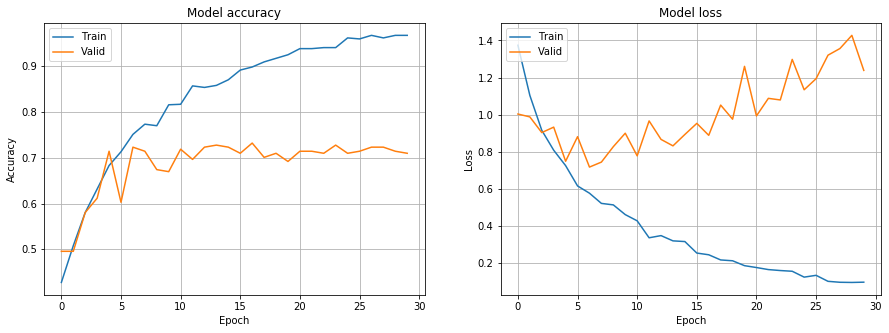

In [34]:
# Plotting the training curves

fig, axs = plt.subplots(1, 2, figsize= (15, 5))

# Plot training & validation accuracy values
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Valid'], loc='upper left')
axs[0].grid()

# Plot training & validation loss values
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(['Train', 'Valid'], loc='upper left')
plt.show()

### Evaluating our model

In [35]:
# Loading the best weights
top_model.load_weights("./weights/weights-improvement-07-0.72.hdf5")

In [36]:
evaluation = top_model.evaluate(validation_data, validation_y)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

224/224 [==============================] - 0s 2ms/step
Accuracy on the validation set: 0.723


In [37]:
pred = top_model.predict(validation_data)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 3, 0, 2, 2, 0, 0, 3, 0])

In [38]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [39]:
y_val = valid_set['label'].map(X_val.class_indices).values

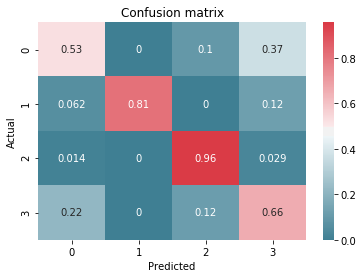

In [40]:
data = {'y_val': y_val[:-2], 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'],
                               normalize= 'index')

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [41]:
print(classification_report(y_val[:-2], y_pred))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        70
           1       1.00      0.81      0.90        16
           2       0.82      0.96      0.88        70
           3       0.60      0.66      0.63        68

    accuracy                           0.72       224
   macro avg       0.78      0.74      0.75       224
weighted avg       0.72      0.72      0.72       224



We didn't manage to have better results than with VGG16.